In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from utils import *

In [2]:
full_data = openml.datasets.get_dataset(14).get_data()[0]

In [3]:
full_data.shape

(2000, 77)

In [4]:
data, _ = train_test_split(full_data, train_size=200)

In [5]:
profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 390 to 925
Data columns (total 77 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   att1    200 non-null    float64 
 1   att2    200 non-null    float64 
 2   att3    200 non-null    float64 
 3   att4    200 non-null    float64 
 4   att5    200 non-null    float64 
 5   att6    200 non-null    float64 
 6   att7    200 non-null    float64 
 7   att8    200 non-null    float64 
 8   att9    200 non-null    float64 
 9   att10   200 non-null    float64 
 10  att11   200 non-null    float64 
 11  att12   200 non-null    float64 
 12  att13   200 non-null    float64 
 13  att14   200 non-null    float64 
 14  att15   200 non-null    float64 
 15  att16   200 non-null    float64 
 16  att17   200 non-null    float64 
 17  att18   200 non-null    float64 
 18  att19   200 non-null    float64 
 19  att20   200 non-null    float64 
 20  att21   200 non-null    float64 
 21  att22   200 non-nul

In [ ]:
n_classes = data['class'].unique().size

---
### CatBoostEncoder

In [7]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [8]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [9]:
best = exp.create_model('et')

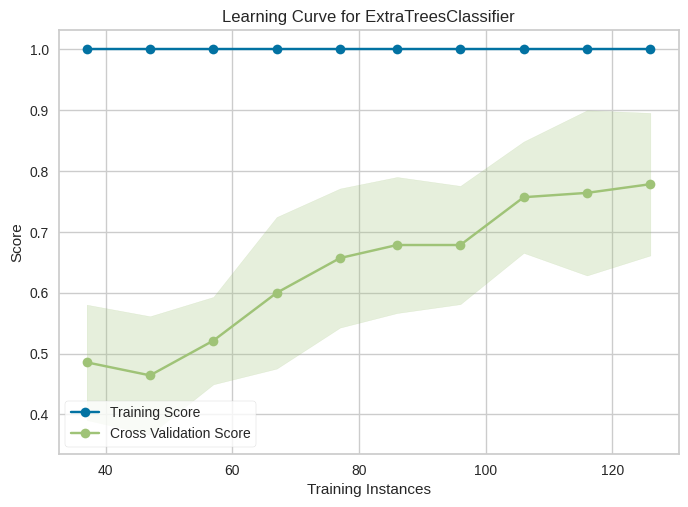

In [10]:
exp.plot_model(best, plot='learning')

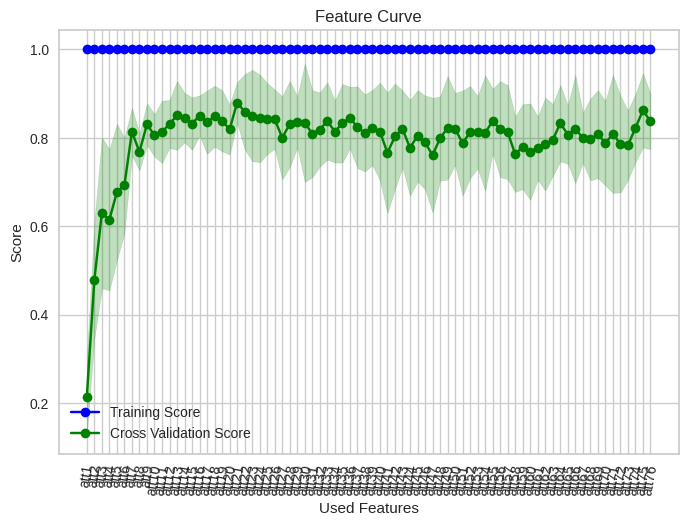

In [11]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed, features_order=exp.X_train_transformed.columns)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

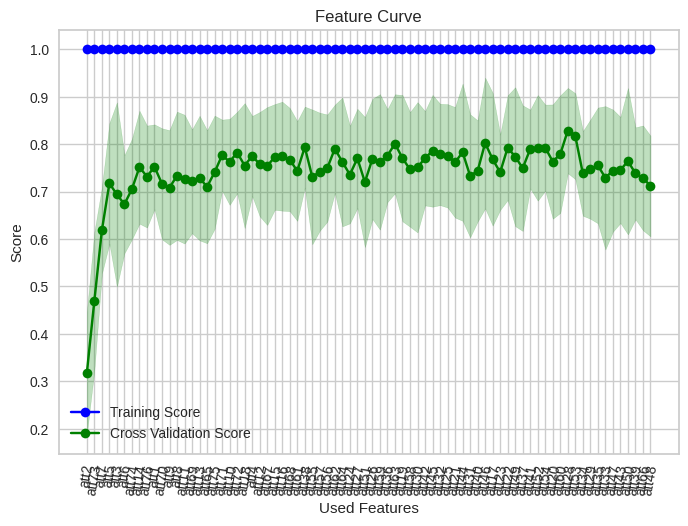

In [12]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

CPU times: user 56.5 s, sys: 44.1 ms, total: 56.6 s
Wall time: 56.6 s


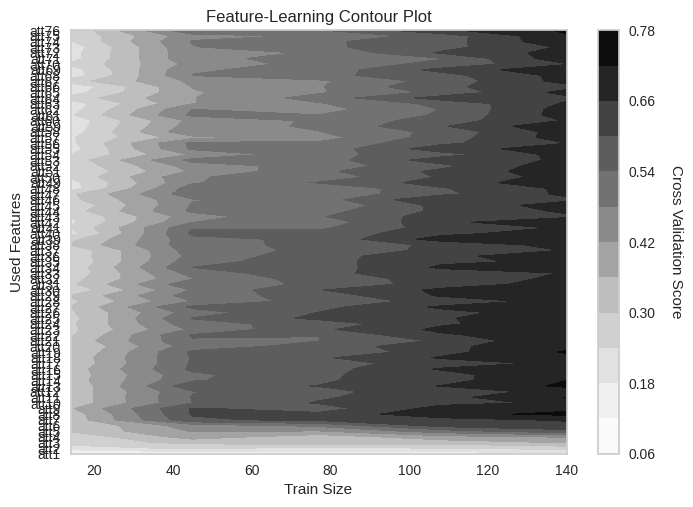

In [13]:
%%time
flc = FeatureLearningCurve(best, exp.X_train_transformed, exp.y_train_transformed, cv=3,
                           features_order=exp.X_train_transformed.columns, scoring=lambda pred, true: f1_score(pred, true, average='macro')
)
flc.fit(exp.X_train_transformed, exp.y_train_transformed, exp.X_test_transformed, exp.y_test_transformed)

---
### TabEBM with CatBoostEncoder

In [14]:
from tabebm.TabEBM import TabEBM

In [15]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

In [16]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [17]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.7522619047619048

In [18]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.7827777777777778

---
### Full data experiement

In [20]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [21]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

---
Let's test the hypotise that only first 16 columns are enough for an accurate classifier

In [27]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data[[*full_data.columns[:15], 'class']],
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [28]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)